**Sketch Recognition Using Deep Learning**

Read the classes names

In [ ]:
f = open("/content/mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

# Download the Dataset

Loop over the classes and download the currospondent data

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
import urllib.request

def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    with open('/content/mini_classes.txt', 'r') as file:
        classes = file.read().splitlines()

    for c in classes:
        cls_url = c.replace('_', '%20')
        path = base + cls_url + '.npy'
        path = path.rstrip()  # Remove trailing whitespace and newline
        print(path)
        urllib.request.urlretrieve(path, 'data/' + c + '.npy')

download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Imports

In [ ]:
import os
import glob
import numpy as np
from tensorflow.python.keras import layers
from tensorflow import keras
import tensorflow as tf

print(len(os.listdir('data')))

100


# Load the Data

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [ ]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [ ]:
print(len(x_train))

320000


Show some random data

bridge


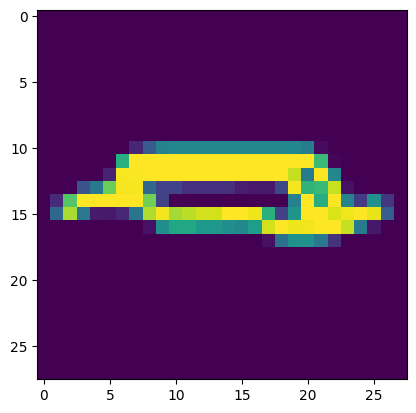

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

# Preprocess the Data

In [ ]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model

In [ ]:
# Define model
model = keras.Sequential()
model.add(keras.layers.Conv2D(16, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size =(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(100, activation='softmax'))

# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

# Training

In [ ]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=10)

Epoch 1/10
1125/1125 - 11s - loss: 1.9475 - top_k_categorical_accuracy: 0.7764 - val_loss: 1.3954 - val_top_k_categorical_accuracy: 0.8752 - 11s/epoch - 10ms/step
Epoch 2/10
1125/1125 - 5s - loss: 1.2503 - top_k_categorical_accuracy: 0.8915 - val_loss: 1.1763 - val_top_k_categorical_accuracy: 0.8995 - 5s/epoch - 5ms/step
Epoch 3/10
1125/1125 - 5s - loss: 1.0930 - top_k_categorical_accuracy: 0.9094 - val_loss: 1.0794 - val_top_k_categorical_accuracy: 0.9097 - 5s/epoch - 5ms/step
Epoch 4/10
1125/1125 - 6s - loss: 1.0049 - top_k_categorical_accuracy: 0.9189 - val_loss: 1.0312 - val_top_k_categorical_accuracy: 0.9154 - 6s/epoch - 5ms/step
Epoch 5/10
1125/1125 - 5s - loss: 0.9445 - top_k_categorical_accuracy: 0.9250 - val_loss: 0.9935 - val_top_k_categorical_accuracy: 0.9190 - 5s/epoch - 5ms/step
Epoch 6/10
1125/1125 - 6s - loss: 0.8994 - top_k_categorical_accuracy: 0.9291 - val_loss: 0.9508 - val_top_k_categorical_accuracy: 0.9233 - 6s/epoch - 5ms/step
Epoch 7/10
1125/1125 - 5s - loss: 0.8

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 93.08%


# Inference

1/1 [==============================] - 0s 33ms/step
['fan: 78.72%', 'ceiling_fan: 11.66%', 'airplane: 4.53%', 'coffee_cup: 1.55%', 'spider: 1.07%']


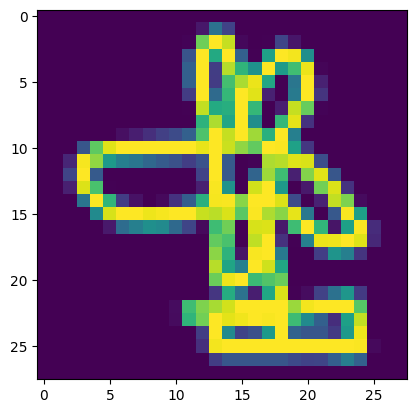

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
pred_percentages = [pred[i] * 100 for i in ind]
latex = [f"{class_names[x]}: {pred_percentages[i]:.2f}%" for i, x in enumerate(ind)]
print(latex)